In [28]:
import requests

import io
import itertools
import datetime
from retry import retry
import multiprocessing as mp

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import ee

import torch
import torchvision
from torchvision import transforms

import shapely.geometry
from shapely.geometry import Point

import geopandas as gpd
import geodatasets
import geocube
import rioxarray

from model.windtopocali import WindTopoCali

ee_crs = 'EPSG:4326'
meter_crs = 'EPSG:5070'
gsd = 100
rtma_gsd = 2500

weather_means = [ 1.56e1, 1.40, -1.55e-1, 6.57e-3, 6.30e-2, 4.49e2, 6.12]
weather_std = [8.21, 2.95, 3.09, 2.61e-3, 4.07e-1, 6.09e2, 3.83]

topo_means = [4.02e2, 6.1135697e+00,  1.46e2, -2.69e8]
topo_std = [6.89e2, 7.82, 1.13e2, 7.11e8]

weather_bands = ['TMP','UGRD','VGRD','SPFH','ACPC01','HGT','GUST']
topo_bands = ['elevation','slope','aspect','mtpi']

ee.Authenticate()
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com',project='eofm-benchmark')

---

Load Saved Model + torch initializations

---

In [4]:
model = WindTopoCali(
    n_weather_channels=7,
    wind_in_size=64,
    n_topo_channels=4,
    topo_in_size=128
)

model.load_state_dict(torch.load('checkpoints/big_exp_lr_100epochs_big_model/epoch_60_checkpoint.pth',weights_only=True))
model.eval()

WindTopoCali(
  (lr_weather_net): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer2): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(

In [5]:
weather_hr_transform = torch.nn.Sequential(
    transforms.CenterCrop(16),
    transforms.Normalize(mean=weather_means,std = weather_std),
    transforms.Resize(64)
)

weather_lr_transform = torch.nn.Sequential(
    transforms.CenterCrop(8),
    transforms.Normalize(mean=weather_means,std = weather_std),
    transforms.Resize(64)
)
topo_hr_transform = torch.nn.Sequential(
    transforms.CenterCrop(400),
    transforms.Normalize(mean = topo_means,std=topo_std),
    transforms.Resize(128)
)

topo_lr_transform = torch.nn.Sequential(
    transforms.CenterCrop(100),
    transforms.Normalize(mean = topo_means,std=topo_std),
    transforms.Resize(128)
)

---

Define Sample Region & Get Coordinates

---

In [8]:
center_lon, center_lat = -123.14, 41.12
time = '2024-01-01T00:00:00'
roi_size = 800

In [9]:
point = Point([center_lon,center_lat])

pp = gpd.GeoSeries(point).set_crs(ee_crs).to_crs(meter_crs).buffer(roi_size)

top, left, bottom, right = pp.total_bounds

gdf_grid = gpd.GeoDataFrame(
    geometry=[
        shapely.geometry.Point(x,y)
        for x in np.arange(top,bottom,gsd)
        for y in np.arange(left,right,gsd)
    ],
    crs=meter_crs
).to_crs(ee_crs)

In [10]:
dt = ee.Date(time)

rtma_proj = ee.Projection(crs='EPSG:5070').atScale(meters=rtma_gsd)

topo_proj = ee.Projection(crs='EPSG:5070').atScale(meters=gsd)


In [11]:
def get_topo_tile(point,proj_topo):
    lon, lat = point.x, point.y

    topo_projection = proj_topo.getInfo()

    topo_point = ee.Geometry.Point(coords=[lon,lat]).transform(proj_topo)
    topo_box = topo_point.buffer(distance=25000).bounds(proj=proj_topo,maxError=0.1)


    #terrain
    dem = ee.Image('USGS/SRTMGL1_003').clip(topo_box).select('elevation')
    slope = ee.Terrain.slope(dem).rename('slope')
    aspect = ee.Terrain.aspect(dem).rename('aspect')
    mtpi = ee.Image('CSP/ERGo/1_0/Global/SRTM_mTPI').clip(topo_box).select('elevation').rename('mtpi')

    topo_frame = dem.addBands(slope).addBands(aspect).addBands(mtpi)


    topo_crs = topo_projection['crs']
    topo_trns = topo_projection['transform']

    topo_url = topo_frame.getDownloadURL(
        {
            'bands':['elevation','slope','aspect','mtpi'],
            'region':topo_box,
            'scale':100,
            'crs':topo_crs,
            'crsTransform':topo_trns,
            'format':'NPY'
        }
    )

    response = requests.get(topo_url)
    if response.status_code != 200:
        raise response.raise_for_status()

    topo_data = np.load(io.BytesIO(response.content))

    return topo_data

    

In [12]:
def get_rtma_tile(point,date,proj_rtma):
    lon, lat = point.x, point.y

    rtma_projection = proj_rtma.getInfo()
    rtma_point = ee.Geometry.Point(coords=[lon,lat]).transform(proj_rtma)
    rtma_box = rtma_point.buffer(distance=25000).bounds(proj=proj_rtma,maxError=0.1)
    
    #weather
    rtma_frame = ee.ImageCollection('NOAA/NWS/RTMA') \
        .filterDate(date,date.advance(1,'hour')) \
        .filterBounds(rtma_box) \
        .first() \
        .clip(rtma_box) \
        .select(['TMP','UGRD','VGRD','SPFH','ACPC01','HGT','GUST'])
    
    rtma_crs = rtma_projection['crs']
    rtma_transform = rtma_projection['transform']

    rtma_url = rtma_frame.getDownloadURL(
        {
            'bands':['TMP','UGRD','VGRD','SPFH','ACPC01','HGT','GUST'],
            'region':rtma_box,
            'scale':2500,
            'crs':rtma_crs,
            'crsTransform':rtma_transform,
            'format':'NPY'
        }
    )

    response = requests.get(rtma_url)
    if response.status_code != 200:
        raise response.raise_for_status()
    rtma_data = np.load(io.BytesIO(response.content))

    return rtma_data

In [13]:
@retry(tries=100,delay=3,backoff=2)
def build_request(idx,point,date=dt,proj_rtma=rtma_proj,proj_topo=topo_proj):
    lon, lat = point.x, point.y


    rtma_projection = proj_rtma.getInfo()
    topo_projection = proj_topo.getInfo()
    
    rtma_point = ee.Geometry.Point(coords=[lon,lat]).transform(proj_rtma)
    rtma_box = rtma_point.buffer(distance=25000).bounds(proj=proj_rtma,maxError=0.1)

    topo_point = ee.Geometry.Point(coords=[lon,lat]).transform(proj_topo)
    topo_box = topo_point.buffer(distance=25000).bounds(proj=proj_topo,maxError=0.1)


    #terrain
    dem = ee.Image('USGS/SRTMGL1_003').clip(topo_box).select('elevation')
    slope = ee.Terrain.slope(dem).rename('slope')
    aspect = ee.Terrain.aspect(dem).rename('aspect')
    mtpi = ee.Image('CSP/ERGo/1_0/Global/SRTM_mTPI').clip(topo_box).select('elevation').rename('mtpi')

    topo_frame = dem.addBands(slope).addBands(aspect).addBands(mtpi)


    topo_crs = topo_projection['crs']
    topo_trns = topo_projection['transform']

    topo_url = topo_frame.getDownloadURL(
        {
            'bands':['elevation','slope','aspect','mtpi'],
            'region':topo_box,
            'scale':100,
            'crs':topo_crs,
            'crsTransform':topo_trns,
            'format':'NPY'
        }
    )
    
    # print(f'Topo Download URL: {topo_url}')

    #weather
    rtma_frame = ee.ImageCollection('NOAA/NWS/RTMA') \
        .filterDate(date,date.advance(1,'hour')) \
        .filterBounds(rtma_box) \
        .first() \
        .clip(rtma_box) \
        .select(['TMP','UGRD','VGRD','SPFH','ACPC01','HGT','GUST'])
    
    rtma_crs = rtma_projection['crs']
    rtma_transform = rtma_projection['transform']

    rtma_url = rtma_frame.getDownloadURL(
        {
            'bands':['TMP','UGRD','VGRD','SPFH','ACPC01','HGT','GUST'],
            'region':rtma_box,
            'scale':2500,
            'crs':rtma_crs,
            'crsTransform':rtma_transform,
            'format':'NPY'
        }
    )

    response = requests.get(rtma_url)
    if response.status_code != 200:
        raise response.raise_for_status()
    rtma_data = np.load(io.BytesIO(response.content))
    
    print(f'ID: {idx} RTMA loaded')
    
    response = requests.get(topo_url)
    if response.status_code != 200:
        raise response.raise_for_status()

    topo_data = np.load(io.BytesIO(response.content))
    print(f'ID: {idx} Topo Loaded')
    

    data = {
        'coordinates':[lon,lat],
        'rtma':rtma_data,
        'topo':topo_data
    }

    return idx,data

In [ ]:
pool = mp.Pool(25)
results = pool.starmap(build_request,enumerate(gdf_grid.geometry))
pool.close()
pool.join()

In [ ]:
results_dict = dict(results)

In [ ]:
weather_ims = [np.stack([results_dict[i]['rtma'][band] for band in weather_bands]) for i in results_dict.keys()] 
topo_ims = [np.stack([results_dict[i]['topo'][band] for band in topo_bands]) for i in results_dict.keys()]
im_source_coords = np.array([results_dict[i]['coordinates'] for i in results_dict.keys()])

In [ ]:
def prepare_batch(batch_idxs,weather_ims,topo_ims):
    weather_lr_tensors = []
    weather_hr_tensors = []
    topo_lr_tensors = []
    topo_hr_tensors = []

    for i, (weather_im, topo_im) in enumerate(zip(weather_ims[batch_idxs],topo_ims[batch_idxs])):
        weather_tensor = torch.from_numpy(weather_im).float()
        topo_tensor = torch.from_numpy(topo_im).float()

        weather_lr_tensor = weather_lr_transform(weather_tensor)
        weather_hr_tensor = weather_hr_transform(weather_tensor)

        topo_lr_tensor = topo_lr_transform(topo_tensor)
        topo_hr_tensor = topo_hr_transform(topo_tensor)

        weather_lr_tensors.append(weather_lr_tensor)
        weather_hr_tensors.append(weather_hr_tensor)

        topo_lr_tensors.append(topo_lr_tensor)
        topo_hr_tensors.append(topo_hr_tensor)



    weather_lr_tensors = torch.stack(weather_lr_tensors)
    weather_hr_tensors = torch.stack(weather_hr_tensors)

    topo_lr_tensors = torch.stack(topo_lr_tensors)
    topo_hr_tensors = torch.stack(topo_hr_tensors)

    batch = {
        'rtma':weather_hr_tensors,
        'rtma_lr':weather_lr_tensors,
        'topo':topo_hr_tensors,
        'topo_lr':topo_lr_tensors
    }

    return batch

In [ ]:
weather_ims = [np.stack([results_dict[i]['rtma'][band] for band in weather_bands]) for i in results_dict.keys()] 
topo_ims = [np.stack([results_dict[i]['topo'][band] for band in topo_bands]) for i in results_dict.keys()]
im_source_coords = np.array([results_dict[i]['coordinates'] for i in results_dict.keys()])

weather_lr_tensors = []
weather_hr_tensors = []
topo_lr_tensors = []
topo_hr_tensors = []

for i, (weather_im, topo_im) in enumerate(zip(weather_ims,topo_ims)):
    weather_tensor = torch.from_numpy(weather_im).float()
    topo_tensor = torch.from_numpy(topo_im).float()

    weather_lr_tensor = weather_lr_transform(weather_tensor)
    weather_hr_tensor = weather_hr_transform(weather_tensor)

    topo_lr_tensor = topo_lr_transform(topo_tensor)
    topo_hr_tensor = topo_hr_transform(topo_tensor)

    weather_lr_tensors.append(weather_lr_tensor)
    weather_hr_tensors.append(weather_hr_tensor)

    topo_lr_tensors.append(topo_lr_tensor)
    topo_hr_tensors.append(topo_hr_tensor)



weather_lr_tensors = torch.stack(weather_lr_tensors)
weather_hr_tensors = torch.stack(weather_hr_tensors)

topo_lr_tensors = torch.stack(topo_lr_tensors)
topo_hr_tensors = torch.stack(topo_hr_tensors)

In [ ]:
num_batches = (len(weather_lr_tensors) // 128) + 1

predicitions = []

batches = np.array_split(np.arange(len(weather_lr_tensors)),num_batches)
for batch_idxs in batches:
    batch = prepare_batch(batch_idxs,weather_ims,topo_ims)
    batch_predicitions = model(batch).detach().numpy()
    predicitions.append(batch_predicitions)

predicitions = np.concatenate(predicitions,axis=0)

In [ ]:
pred_df = pd.DataFrame({
    'UWND':predicitions[:,0],
    'VWND':predicitions[:,1],
    'lon':im_source_coords[:,0],
    'lat':im_source_coords[:,1]
})
pred_gdf = gpd.GeoDataFrame(pred_df,geometry=gpd.points_from_xy(pred_df.lon,pred_df.lat),crs='EPSG:4326').to_crs('EPSG:5070')

In [ ]:
import rioxarray
import xarray as xr
from geocube.api.core import make_geocube

out_grid = make_geocube(
    vector_data=pred_gdf,
    measurements=['UWND','VWND'],
    resolution=(-100,100),
    # interpolate_na_method='cubic'
) 

In [15]:
eval_station_fname = './data/eval_stations.csv'
eval_station_df = pd.read_csv(eval_station_fname)
eval_station_df['DATE'] = pd.to_datetime(eval_station_df['DATE'],format='%Y-%m-%dT%H:%M:%S')
eval_station_df['DATE'] = eval_station_df['DATE'].dt.round('h')
eval_station_df['DAY'] = eval_station_df['DATE'].dt.day_of_year

In [16]:
eval_station_aggregates = eval_station_df.groupby(by=['DAY','STATION'],as_index=False).mean()
eval_station_aggregates['STATION']

0       72026723224
1       72286023119
2       72288023152
3       72376293244
4       72381603159
           ...     
3590    72381603159
3591    72392793110
3592    72492023237
3593    72495723213
3594    74505753130
Name: STATION, Length: 3595, dtype: int64

In [31]:
test_station = 72286023119
doys = range(1,366,1)
months = range(1,13,1)
hrs = 24

time = '2024-01-01T00:00:00'

station_data = eval_station_aggregates[eval_station_aggregates['STATION'] == test_station]

lon, lat = station_data['LONGITUDE'].iloc[0], station_data['LATITUDE'].iloc[0]

location = shapely.geometry.Point(lon,lat)
topo = get_topo_tile(point,topo_proj)
topo_im = np.stack([topo[band] for band in topo_bands])

station_eval_results = []
for doy in doys:
    hr = np.random.randint(0,hrs,size=1)

    dt = datetime.datetime.strptime(f'2022-{doy}T{str(hr[0]).zfill(2)}:00:00','%Y-%jT%H:%M:%S')

    rtma = get_rtma_tile(point,ee.Date(dt),rtma_proj)
    weather_im = np.stack([rtma[band] for band in weather_bands])

    weather_tensor = torch.from_numpy(weather_im).float()
    topo_tensor = torch.from_numpy(topo_im).float()

    weather_lr_tensor = weather_lr_transform(weather_tensor)
    weather_hr_tensor = weather_hr_transform(weather_tensor)

    topo_lr_tensor = topo_lr_transform(topo_tensor)
    topo_hr_tensor = topo_hr_transform(topo_tensor)

    batch = {
        'rtma':torch.unsqueeze(weather_hr_tensor,dim=0),
        'rtma_lr':torch.unsqueeze(weather_lr_tensor,dim=0),
        'topo':torch.unsqueeze(topo_hr_tensor,dim=0),
        'topo_lr':torch.unsqueeze(topo_lr_tensor,dim=0)
    }
    predicition = model(batch).detach().numpy()

    station_eval_result = {'STATION':test_station,'DAY':doy,'UWNDPred':predicition[0,0],'VWNDPred':predicition[0,1]}
    station_eval_results.append(station_eval_result)

station_eval_results = pd.DataFrame(station_eval_results)
    

In [32]:
station_eval_results

,STATION,DAY,UWNDPred,VWNDPred
0,72286023119,1,-0.480852,-2.758042
1,72286023119,2,-0.550776,-2.512285
2,72286023119,3,-0.379256,-2.338024
3,72286023119,4,-0.244290,-2.566725
4,72286023119,5,-0.438577,-2.647578
...,...,...,...,...
360,72286023119,361,-0.381349,-2.274046
361,72286023119,362,-0.596008,-2.695763
362,72286023119,363,-0.471291,-2.366705
363,72286023119,364,-0.362700,-2.173361


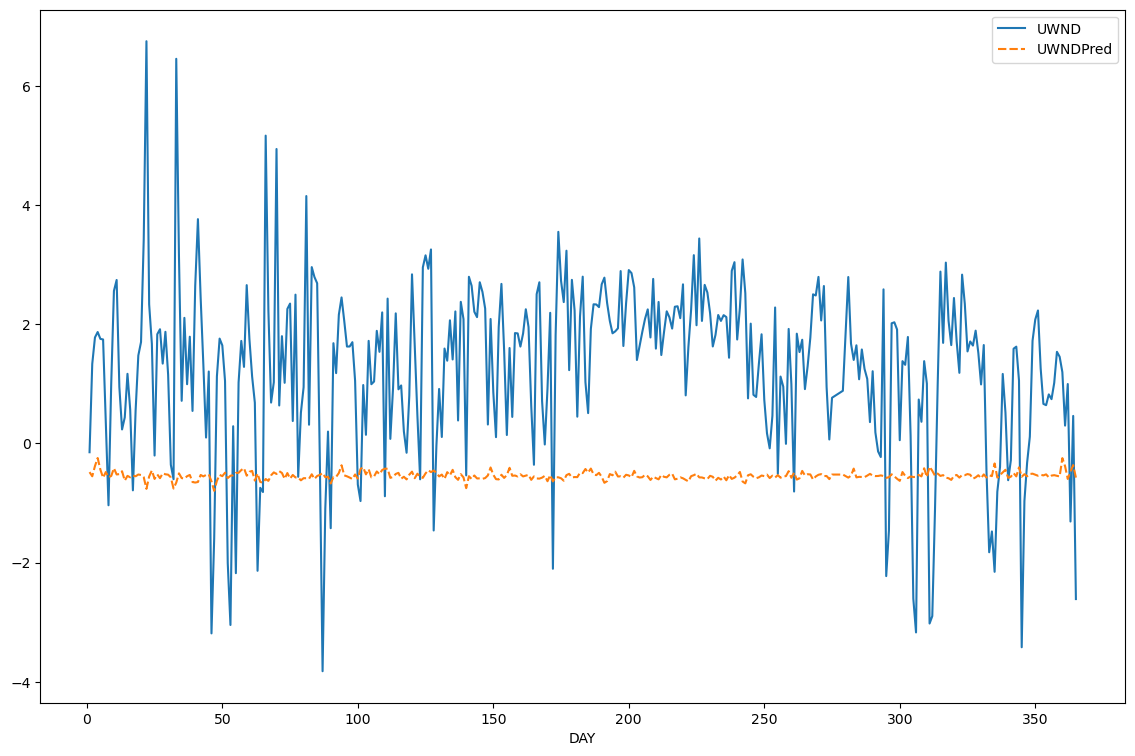

In [40]:
station_eval_viz = station_eval_results.merge(station_data,on=['STATION','DAY'])
columns_plot = ['UWND','UWNDPred']
colors = ['r','b']

station_eval_viz_uwnd = station_eval_viz[['DAY','UWND','UWNDPred']].set_index('DAY')

fig, ax = plt.subplots(figsize=(14,9))
sns.lineplot(station_eval_viz_uwnd)
# for var, color in zip(columns_plot,colors):
#     sns.lineplot(station_eval_viz,x='DAY',y=var,hue=color)
plt.show()

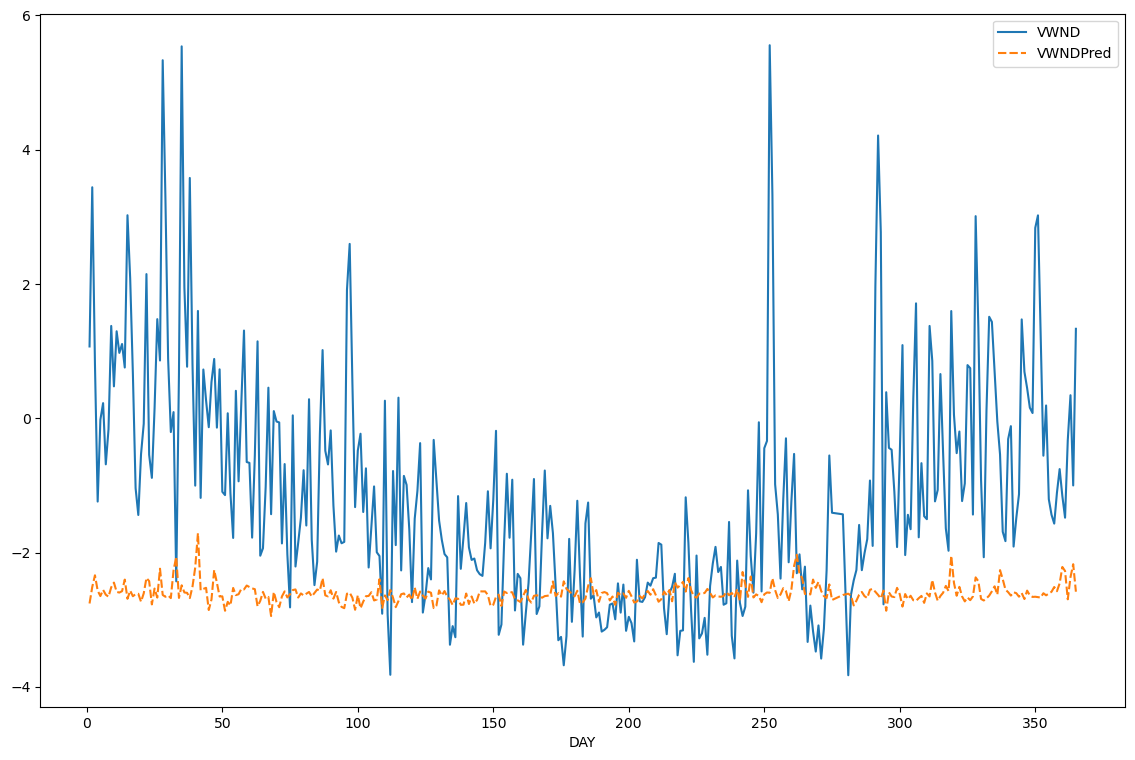

In [39]:
station_eval_viz_uwnd = station_eval_viz[['DAY','VWND','VWNDPred']].set_index('DAY')

fig, ax = plt.subplots(figsize=(14,9))
sns.lineplot(station_eval_viz_uwnd)

plt.show()